## Set Up and Load Data

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 15)

In [105]:
df = pd.read_csv('dataset/train.csv', index_col='PassengerId')
df.drop(['Name'], axis=1, inplace=True)

## EDA

In [106]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 823.5+ KB


In [108]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0].index

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
      dtype='object')

In [109]:
missing_values

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [110]:
columns_with_missing = missing_values[missing_values > 0].index.tolist()
columns_with_missing

['HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

In [111]:
# Split cabin structure
df['Deck'] = df['Cabin'].str.split('/').str[0]
df['Side'] = df['Cabin'].str.split('/').str[-1]

In [112]:
# Select columns based on dtypes
df['Deck'] = df['Cabin'].str.split('/').str[0] # Split cabin structure
bool_cols = ['Transported','VIP']
df[bool_cols] = df[bool_cols].astype(bool)
df[bool_cols] = df[bool_cols].astype(int)
object_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(exclude='object').columns.tolist()
for col in object_cols:
    print(f'Unique values of {col}: {df[col].unique()}')
print('\n')
print(f'Boolean columns: {bool_cols}\nCategory columns: {object_cols}\nNumerical columns:{num_cols}')

Unique values of HomePlanet: ['Europa' 'Earth' 'Mars' nan]
Unique values of CryoSleep: [False True nan]
Unique values of Cabin: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Unique values of Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Unique values of Deck: ['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
Unique values of Side: ['P' 'S' nan]


Boolean columns: ['Transported', 'VIP']
Category columns: ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Deck', 'Side']
Numerical columns:['Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']


In [113]:
df['CryoSleep'].unique()

array([False, True, nan], dtype=object)

In [114]:
df['CryoSleep'].value_counts()

CryoSleep
False    5439
True     3037
Name: count, dtype: int64

In [115]:
home_transported = df[['HomePlanet','Transported']].copy()
home_transported['HomePlanet'].fillna('Missing', inplace=True)
home_transported = pd.DataFrame(home_transported.groupby(['HomePlanet','Transported']).size()).reset_index()
home_transported.columns = ['HomePlanet','Transported','Count']
for i in home_transported.HomePlanet.unique().tolist():
    for j in home_transported.Transported.unique().tolist():
        count = home_transported[(home_transported['HomePlanet'] == i) & (home_transported['Transported'] == j)]['Count']
        home_transported.loc[(home_transported['HomePlanet'] == i) & (home_transported['Transported'] == j), 'percentage'] = round(count/(home_transported.groupby('HomePlanet')['Count'].sum()[i])*100,2)

In [116]:
df.head(10)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,P
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,S
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,S
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,S
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,S
0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,0,0.0,483.0,0.0,291.0,0.0,1,F,P
0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,0,42.0,1539.0,3.0,0.0,0.0,1,F,S
0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,0,0.0,0.0,0.0,0.0,NaN,1,G,S
0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,0,0.0,785.0,17.0,216.0,0.0,1,F,S


In [117]:
df['Deck'].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [118]:
df['Side'].unique()

array(['P', 'S', nan], dtype=object)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8693 non-null   int64  
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   int64  
 12  Deck          8494 non-null   object 
 13  Side          8494 non-null   object 
dtypes: float64(6), int64(2), object(6)
memory usage: 1018.7+ KB


Text(0.5, 1.0, 'Distribution of Missing Values')

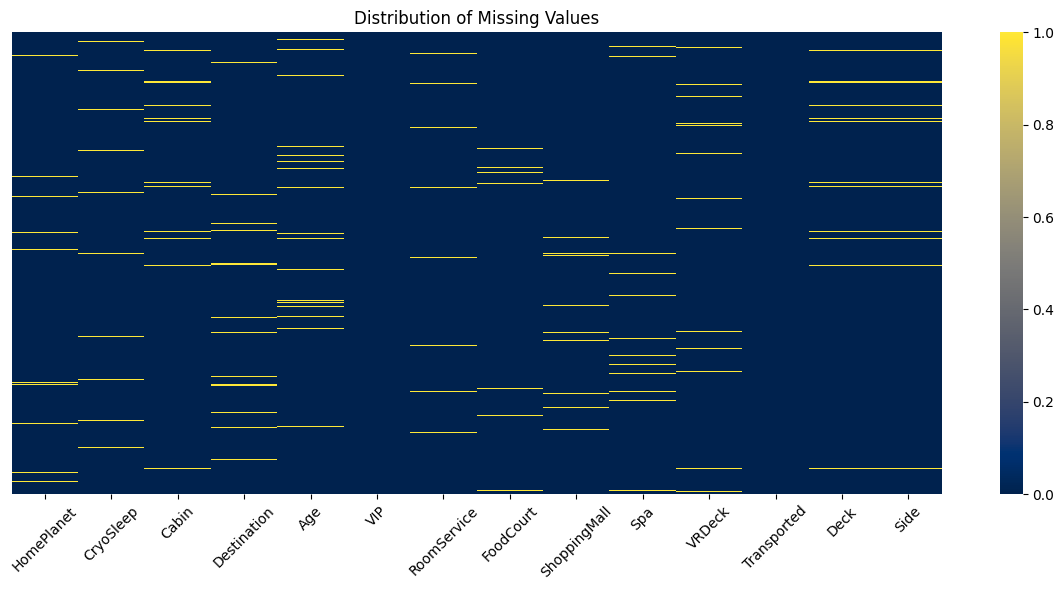

In [120]:
plt.figure(figsize=(15,6))
ax = sns.heatmap(data=df.reset_index().drop('PassengerId', axis=1).isnull(), cbar=True, cmap='cividis', yticklabels=False)
plt.xticks(rotation=45)
plt.title('Distribution of Missing Values')

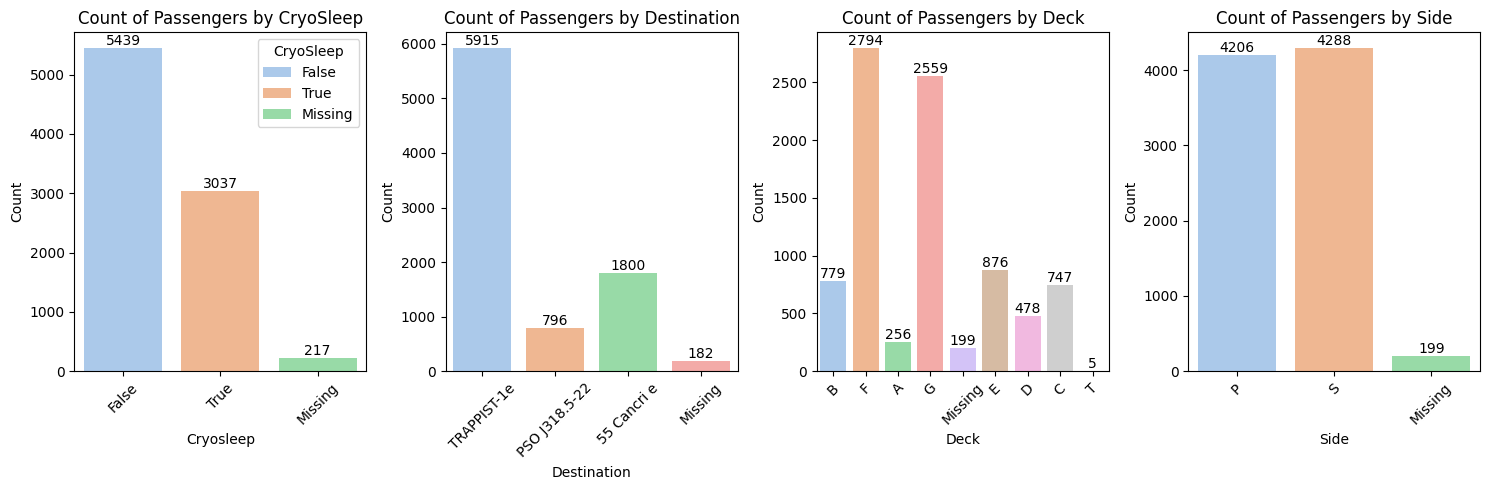

In [237]:
selected_col = [col for col in object_cols if col != 'Cabin']
sample_df = df.copy()
sample_df.fillna('Missing', inplace=True)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
ax = ax.ravel()
for i, col in enumerate(selected_col):
    sns.countplot(x=col, data=sample_df, palette='pastel',hue=col, ax=ax[i])
    for container in ax[i].containers:
        ax[i].bar_label(container, color='black', size=10)
    ax[i].set_title(f'Count of Passengers by {col}')
    ax[i].set_xlabel(col.capitalize())
    ax[i].set_ylabel('Count')
    ax[i].tick_params(axis='x', rotation = 45)
plt.tight_layout()
plt.show()

<Axes: >

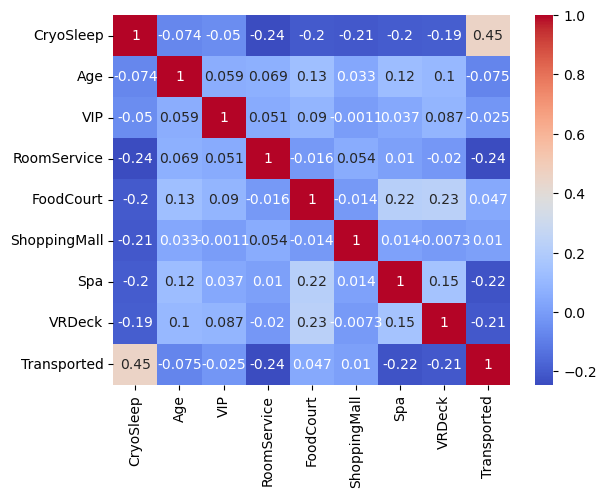

In [ ]:
# Correlation Matrix of Numerical columns
num_corr = df[num_cols].corr()
sns.heatmap(num_corr, annot=True, cmap='coolwarm')

In [234]:
# Function to see rela between HomePlanet and other features
def category_col_rela(dataframe, target_col, feature_col):
    sample_df = dataframe[[target_col,feature_col]].copy().reset_index().drop('PassengerId', axis=1)
    sample_df.fillna('Missing', inplace=True) 
    sample_df = pd.DataFrame(sample_df.groupby([target_col])[feature_col].value_counts())
    totals = sample_df.groupby([target_col])['count'].transform(sum)
    sample_df['percentage'] = sample_df['count']/totals*100
    sample_df_pivot = sample_df.pivot_table(index=target_col, columns=feature_col, values='percentage', aggfunc='sum', fill_value=0)
    plot = sample_df_pivot.plot(kind='bar', stacked=True, figsize=(10, 5.5), rot=0, legend=True, ylabel='Percentage', title=f'Distribution of {feature_col} by {target_col}')
    plot.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    return sample_df, plot, sample_df_pivot

## Clean HomePlanet

1. Data Structure for Stacked Bars
In a stacked bar chart, you need a DataFrame where:
- The index represents the categories for the bars (e.g., HomePlanet).
- The columns represent the different segments of the bars (e.g., Transported status).
- The values in the DataFrame represent the heights of these segments.

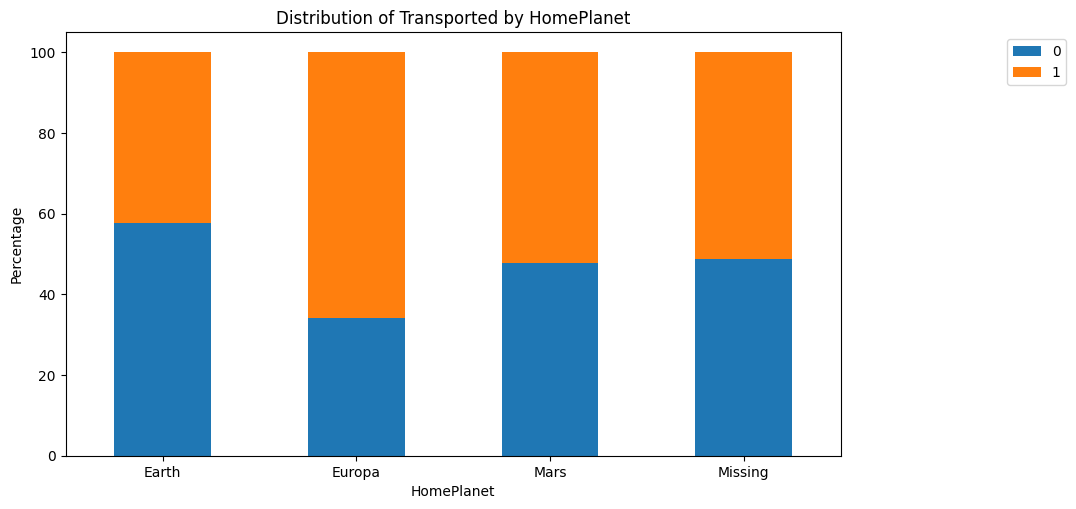

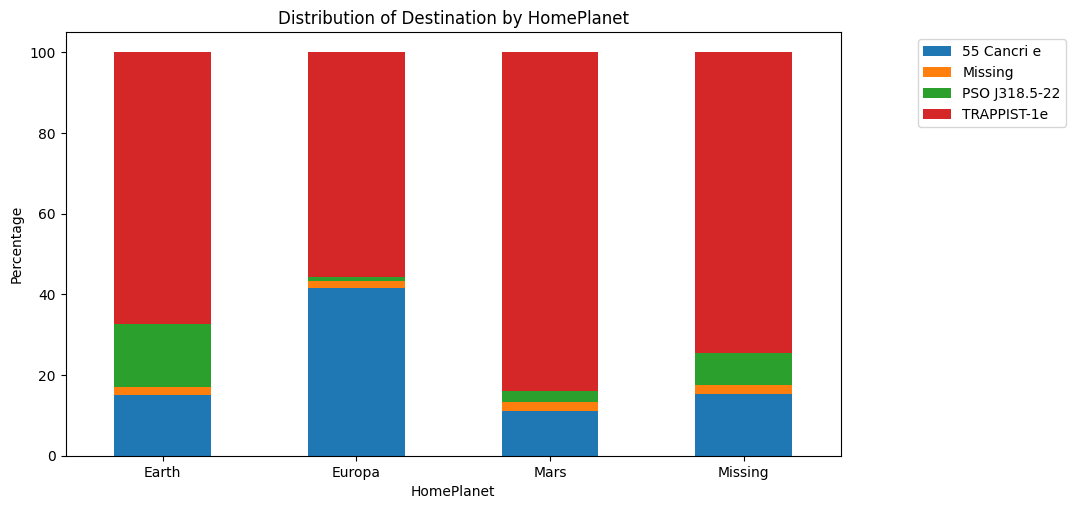

In [236]:
# Relationship between HomePlanet and Transported status
home_transported, plot_home_transported, data_pivot = category_col_rela(df,'HomePlanet', 'Transported')
# Distribution of Destination by HomePlanet

home_dest, plot_home_dest, data_pivot = category_col_rela(df, 'HomePlanet','Destination')

In [242]:
df_homeplanet = df.copy().drop('Transported', axis=1)

In [245]:
num_cols = ['Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

In [246]:
# Select features and target for machine learning model

features = df_homeplanet[df_homeplanet['HomePlanet'].notna()].drop(columns=['Cabin', 'HomePlanet'])  # Get features data without HomePlanet and Cabin
object_features = ['CryoSleep', 'Deck','Side','Destination']
features[object_features] = features[object_features].fillna('Missing')
features['CryoSleep'] = features['CryoSleep'].astype(str)
impute_mean = SimpleImputer(strategy='mean') # Temporary filling mean values for NA cells
features[num_cols] = impute_mean.fit_transform(features[num_cols]) # Filling Missing for NA cells


target = pd.DataFrame(df_homeplanet[df_homeplanet['HomePlanet'].notna()].HomePlanet) # Get HomePlanet which is NA only
test_homeplanet_df = df_homeplanet[df_homeplanet['HomePlanet'].isna()].drop('Cabin', axis=1)

In [124]:
test_homeplanet_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
PassengerId,,,,,,,,,,,,,
0064_02,NaN,True,TRAPPIST-1e,33.0,0,0.0,0.0,NaN,0.0,0.0,1,E,S
0119_01,NaN,False,TRAPPIST-1e,39.0,0,0.0,2344.0,0.0,65.0,6898.0,0,A,P
0210_01,NaN,True,55 Cancri e,24.0,0,0.0,0.0,NaN,0.0,0.0,1,D,P
0242_01,NaN,False,TRAPPIST-1e,18.0,0,313.0,1.0,691.0,283.0,0.0,0,F,S
0251_01,NaN,True,55 Cancri e,54.0,0,0.0,0.0,0.0,0.0,0.0,1,C,S


In [247]:
# Label Encoding for target
label_encoder = LabelEncoder()
encoded_target = label_encoder.fit_transform(target)
encoded_target

/Users/ezishr/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 0, 1, ..., 0, 1, 1])

In [248]:
# One Hot Encoding
def one_hot_encoding_obj_features(df, object_columns, numerical_cols):
    one_hot_encoder = OneHotEncoder(sparse=False)
    encoded_features = one_hot_encoder.fit_transform(df[object_columns])
    encoded_features_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(object_columns))
    encoded_features_df.set_index(df.index, inplace=True)

    final_features = pd.concat([encoded_features_df, df[numerical_cols]], axis=1)
    return final_features

features = one_hot_encoding_obj_features(features, object_features, num_cols)
sample = test_homeplanet_df.copy().drop(columns='HomePlanet')
sample[object_features] = sample[object_features].fillna('Missing')
sample[num_cols] = impute_mean.fit_transform(sample[num_cols])
sample['CryoSleep'] = sample['CryoSleep'].astype(str)
X_test = one_hot_encoding_obj_features(sample,object_features,num_cols)

In [249]:
# Split features and target into different set
X_train, X_val, y_train, y_val = train_test_split(features, encoded_target, train_size=0.8, test_size=0.2, random_state=1)

y_test = pd.DataFrame(test_homeplanet_df['HomePlanet'])
y_test

,HomePlanet
PassengerId,
0064_02,NaN
0119_01,NaN
0210_01,NaN
0242_01,NaN
0251_01,NaN
...,...
9084_01,NaN
9194_01,NaN
9248_01,NaN


In [250]:
# Build Decision Tree Classifier Model
decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(X_train, y_train)

# Predictions based on validation set
y_pred = decision_tree.predict(X_val)
print('Accuracy score based on validation set:',accuracy_score(y_val, y_pred))

# Cross-validation
print('Cross validation score:',cross_val_score(decision_tree, X_train, y_train, cv = 5, scoring = 'accuracy'))

Accuracy score based on validation set: 0.898175397292525
Cross validation score: [0.92200147 0.90434143 0.9205298  0.90942563 0.92120766]


In [251]:
# Build Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100,random_state=1)
random_forest.fit(X_train, y_train)
y_rd_pred = random_forest.predict(X_val)
print('Accuracy score based on validation set:',accuracy_score(y_val, y_rd_pred))
print('Cross validation score:',cross_val_score(random_forest, X_train, y_train, cv = 5, scoring='accuracy'))

Accuracy score based on validation set: 0.9264273101824603
Cross validation score: [0.93156733 0.93451067 0.93598234 0.93004418 0.93814433]


In [252]:
# Predictions for actual NA by Random Forest
y_filling = random_forest.predict(X_test)
y_test['HomePlanet'] = y_filling

# Decoding predictions
decoded_predictions = pd.DataFrame(label_encoder.inverse_transform(y_test)).set_index(y_test.index)

/Users/ezishr/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [253]:
decoded_predictions

,0
PassengerId,
0064_02,Mars
0119_01,Europa
0210_01,Europa
0242_01,Earth
0251_01,Europa
...,...
9084_01,Mars
9194_01,Europa
9248_01,Earth


In [254]:
df_homeplanet.loc[df_homeplanet['HomePlanet'].isna(), 'HomePlanet'] = decoded_predictions[0]
df_homeplanet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8693 non-null   int64  
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Deck          8494 non-null   object 
 12  Side          8494 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 1.2+ MB


(                      count  percentage
 HomePlanet CryoSleep                   
 Earth      False       3189   67.620865
            True        1413   29.961832
            Missing      114    2.417303
 Europa     False       1181   54.323827
            True         933   42.916283
            Missing       60    2.759890
 Mars       False       1069   59.290072
            True         691   38.325014
            Missing       43    2.384914,
 <Axes: title={'center': 'Distribution of CryoSleep by HomePlanet'}, xlabel='HomePlanet', ylabel='Percentage'>,
 CryoSleep       False       True   Missing
 HomePlanet                                
 Earth       67.620865  29.961832  2.417303
 Europa      54.323827  42.916283  2.759890
 Mars        59.290072  38.325014  2.384914)

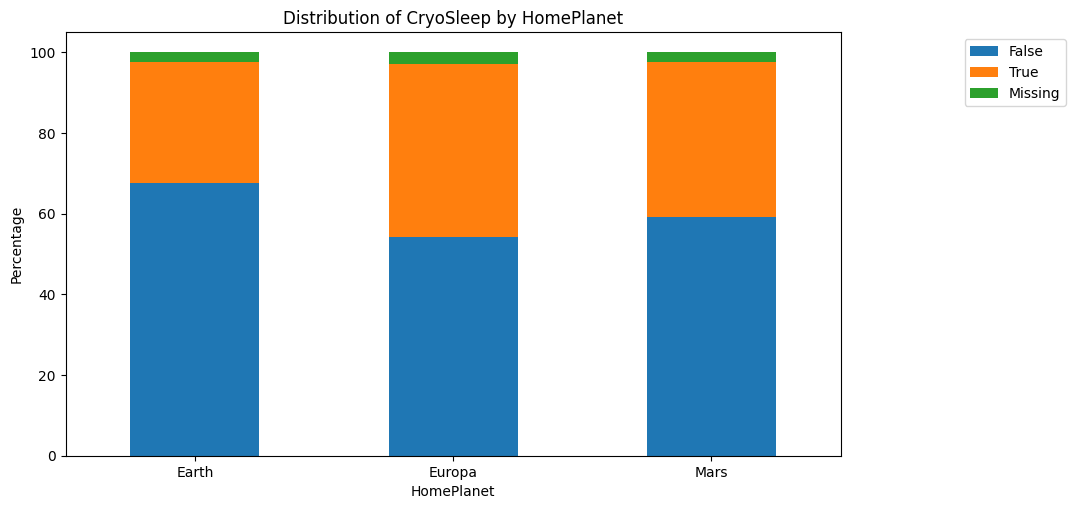

In [255]:
homeplanet_other(df_homeplanet,'CryoSleep')

Text(0.5, 1.0, 'Distribution of Home Planet after Cleansing')

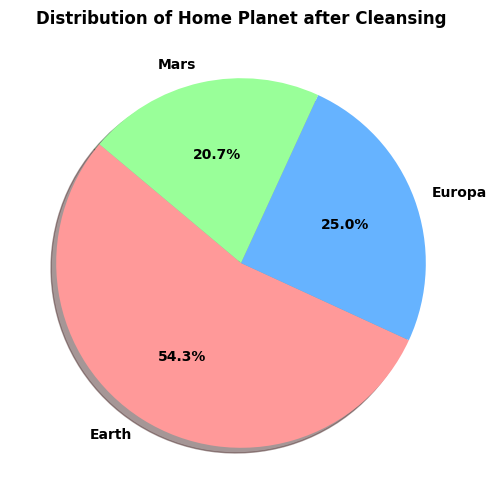

In [256]:
# See distribution of Home Planet after cleansing
data = df_homeplanet['HomePlanet'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(12,6))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, colors = colors, shadow=True, textprops={'fontweight': 'bold'})
plt.title('Distribution of Home Planet after Cleansing', fontweight = 'bold')
# homeplanet_counts: The data for the pie chart.
# labels=homeplanet_counts.index: The labels for each slice of the pie chart.
# autopct='%1.1f%%': Displays the percentage of each slice.
# startangle=140: Rotates the start angle of the pie chart for better visualization.

## Cleansing CryoSleep

In [222]:
df.columns

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Deck', 'Side'],
      dtype='object')

In [257]:
df_cryosleep = df.copy().drop(['Cabin','Transported'], axis=1)

In [259]:
object_cols = ['CryoSleep','Destination', 'Deck', 'Side']
num_cols = ['Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

In [260]:
df_cryosleep.isna().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP               0
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Deck            199
Side            199
dtype: int64

(                         count  percentage
 CryoSleep Destination                     
 False     TRAPPIST-1e     3898   71.667586
           55 Cancri e     1017   18.698290
           PSO J318.5-22    394    7.243979
           Missing          130    2.390145
 True      TRAPPIST-1e     1867   61.475140
           55 Cancri e      739   24.333224
           PSO J318.5-22    383   12.611129
           Missing           48    1.580507
 Missing   TRAPPIST-1e      150   69.124424
           55 Cancri e       44   20.276498
           PSO J318.5-22     19    8.755760
           Missing            4    1.843318,
 <Axes: title={'center': 'Distribution of Destination by CryoSleep'}, xlabel='CryoSleep', ylabel='Percentage'>,
 Destination  55 Cancri e   Missing  PSO J318.5-22  TRAPPIST-1e
 CryoSleep                                                     
 False          18.698290  2.390145       7.243979    71.667586
 True           24.333224  1.580507      12.611129    61.475140
 Missing       

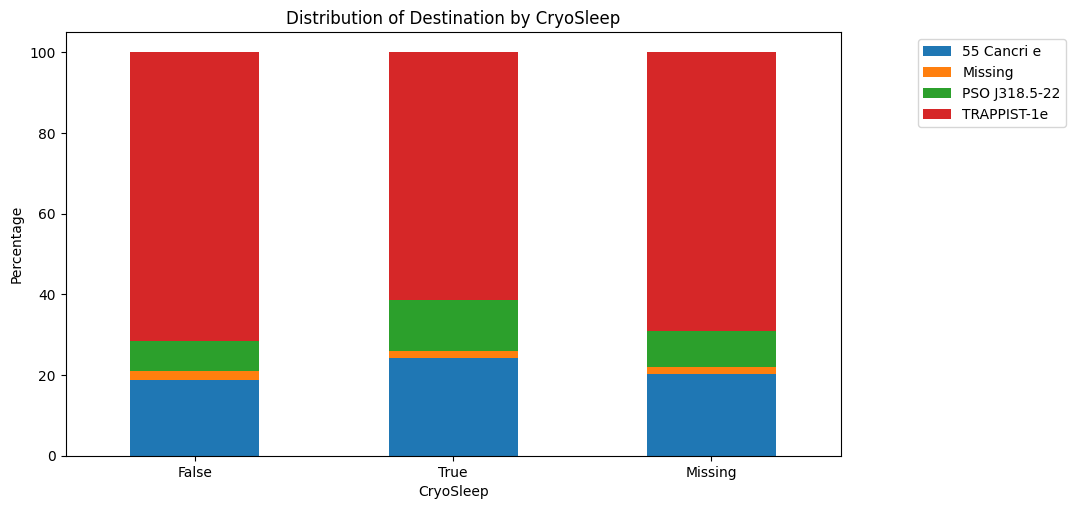

In [261]:
category_col_rela(df_cryosleep,'CryoSleep', 'Destination')

(                   count  percentage
 CryoSleep Deck                      
 False     F         2176   40.007354
           G         1146   21.070050
           E          688   12.649384
           C          430    7.905865
           D          364    6.692407
           B          341    6.269535
           A          182    3.346203
           Missing    108    1.985659
           T            4    0.073543
 True      G         1350   44.451762
           F          550   18.109977
           B          419   13.796510
           C          294    9.680606
           E          168    5.531775
           D          104    3.424432
           Missing     84    2.765887
           A           68    2.239052
 Missing   F           68   31.336406
           G           63   29.032258
           C           23   10.599078
           E           20    9.216590
           B           19    8.755760
           D           10    4.608295
           Missing      7    3.225806
           A

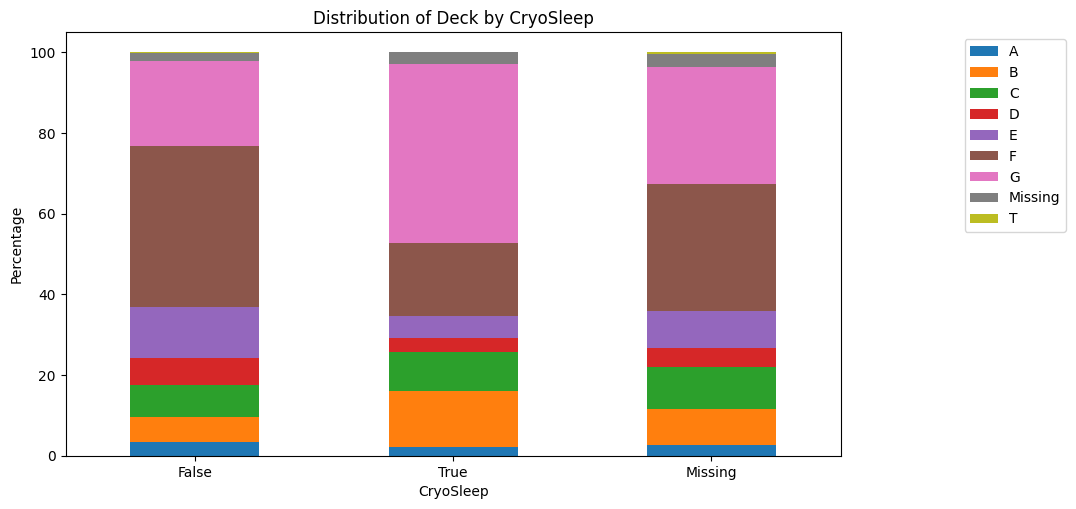

In [262]:
category_col_rela(df_cryosleep,'CryoSleep','Deck')

(                   count  percentage
 CryoSleep Side                      
 False     P         2673   49.145063
           S         2658   48.869277
           Missing    108    1.985659
 True      S         1533   50.477445
           P         1420   46.756668
           Missing     84    2.765887
 Missing   P          113   52.073733
           S           97   44.700461
           Missing      7    3.225806,
 <Axes: title={'center': 'Distribution of Side by CryoSleep'}, xlabel='CryoSleep', ylabel='Percentage'>,
 Side        Missing          P          S
 CryoSleep                                
 False      1.985659  49.145063  48.869277
 True       2.765887  46.756668  50.477445
 Missing    3.225806  52.073733  44.700461)

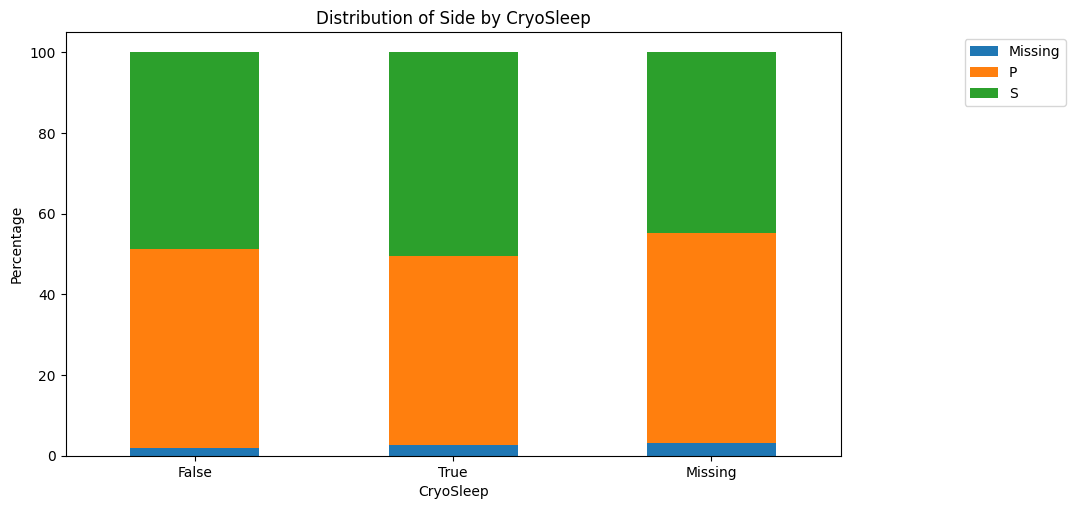

In [263]:
category_col_rela(df_cryosleep,'CryoSleep','Side')